# CAB420, Metric Learning/Encoders and Decoders, Bonus Example: Self Supervised Learning
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

As you can see from the title, this example is straddling a couple of different areas. We're taking the "self-supervised" idea that sits at the heart of an autoencoder, and throwing that up again our old friend, metric learning. What we saw with metric learning was that we could learn a nice, compact representation that put similar samples close to one another. This is very helpful for a lot of tasks, but does have that annoying old requirement that we need to have labels for each example. Self-Supervised learning get's around that.

We borrow the same idea that sits at the centre of the auto-encoder, that we can use the sample as it's own label, and apply this to a siamese network. In an auto-encoder, we exploit this idea by learning a network that will encode, and then decode, the same sample. The output should be identical to the input, but it goes via some stack of neural network layers which will (hopefully) learn some interesting representation we can use later. With a siamese network, we have two identical branches and the network is trained to produce an embedding that will have samples of the same close to each other. Here, rather than provide samples of the same (or different) classes, we simply provide two versions of the same image as our pair. To make the task non-trivial, we use augmentation to ensure that the images in the pair look suitably different.

This whole area of self-supervised learning is a really rapidly advancing area, and we're not going to try and cover all the really awesome stuff here, but we'll look at a few different methods that fit into this space. This example is heavily based off a few keras examples, in particular:
* [Barlow Twins for Contrastive SSL](https://keras.io/examples/vision/barlow_twins/)
* [Self-supervised contrastive learning with SimSiam](https://keras.io/examples/vision/simsiam/)

These have all been modified to be more consistent with each other, with what else we've done in CAB420, and to be a lot faster to execute (no large resnet models here). This means that performance will be limited, but if you have the time (and compute resources) you can scale up the backbone network and get some much better looking numbers.

### Where does this fit into all the other CAB420 content?

First up, **this example really is getting well outside the scope of CAB420**.

If that first line didn't scare you off, this example is a an extension to the metric learning content which incorporates the idea of "self supervised learning" that we saw introduced with autoencoders. The content in here really is creeping well outside the scope of CAB420, you're very unlikely to have any reason to use this stuff in Assignment 2 for example, but it's (I think) interesting and another nice example of learning from no labels.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf

import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras import activations
from keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
import datetime

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

tf.config.optimizer.set_jit(False)

### Constants

The usual set of constants. Feel free to play with these as you see fit.

In [2]:
# Batch size of dataset
BATCH_SIZE = 128
# Width and height of image - probably don't change this unless you change the dataset
IMAGE_SIZE = 32
# random seed to use for dataset creation.
SEED = 42
AUTO = tf.data.AUTOTUNE

# flags to indicate which models to run. You can use these if you want to run just one model.
APPROACH_1 = True
APPROACH_2 = True
APPROACH_3 = True

## The Data
### CIFAR-10
We'll use CIFAR-10 today. We'd get better results with Fashion-MNIST, but we have more augmentation options with CIFAR-10 with these being colour images, so we'll use that.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

### Augmentations

Like Ron Burgundy, augmentation is kind-of a big deal. For self-supervised learning, using the *right* augmentations can have a big impact on performance.

What I have below is a combination of the two augmentation sets from [here](https://keras.io/examples/vision/barlow_twins/) and [here](https://keras.io/examples/vision/simsiam/). In all we have five augmentations, in four functions:
* `flip_random_crop` will left-right flip, and crop the image, giving us two augmentations for the price of one. 
* `color_jitter` will apply some random variations to brightness, contrast, saturation and hue, overall shifting the colour of the image.
* `color_drop` will convert from colour to grayscale.
* `blur` will apply a guassian filter to the image.

The observant student will see that I have a fifth function below, `solarize` that I have neglected to mention. I'm finding that this transform, although used [here](https://keras.io/examples/vision/barlow_twins/), is creating some rather undesirable artefacts in the images and so I've left it out. Including this will not break the network training, so feel free to drop it back in if you wish.

In [4]:
def flip_random_crop(x):
    # With random crops we also apply horizontal flipping.
    x = tf.image.random_flip_left_right(x)

    rand_size = tf.random.uniform(shape=[], minval=int(0.9 * IMAGE_SIZE), maxval=1 * IMAGE_SIZE, dtype=tf.int32)
    x = tf.image.random_crop(x, (rand_size, rand_size, 3))
    x = tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))

    return x

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0.0, 1.0)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

def solarize(x):
    x = tf.where(x < 0.05, x, 1.0 - x)
    return x

#def blur(x):
#    s = np.random.random()
#    return tfm.vision.augment.gaussian_filter2d(image=x, shape=(3,3), sigma=s)

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x
    
def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
#    image = random_apply(blur, image, p=0.2)
    image = random_apply(solarize, image, p=0.2)
    image = random_apply(color_drop, image, p=0.2)
    return image

We'll create to datasets for this now, and we'll create two datasets as we want pairs of images. Both will use the same data and same augmentation. Critically, we'll give both the same seed, so that the images end up in the exact same order in both. This is really important as we are relying on having paired data (our whole training approach is based around having two versions of the same image going into the model).

In [5]:
with tf.device('CPU'):

    # first dataset
    ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
    ssl_ds_one = (ssl_ds_one.shuffle(256, seed=SEED).map(custom_augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

    # second dataset - identical settings to the first
    ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
    ssl_ds_two = (ssl_ds_two.shuffle(256, seed=SEED).map(custom_augment, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO))

    # combine both the datasets, meaning that when we draw a sample we'll get image pairs, but with different augmentations
    # applied to each image
    ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

For a sanity check (what else), we pull out a few images and have a look.

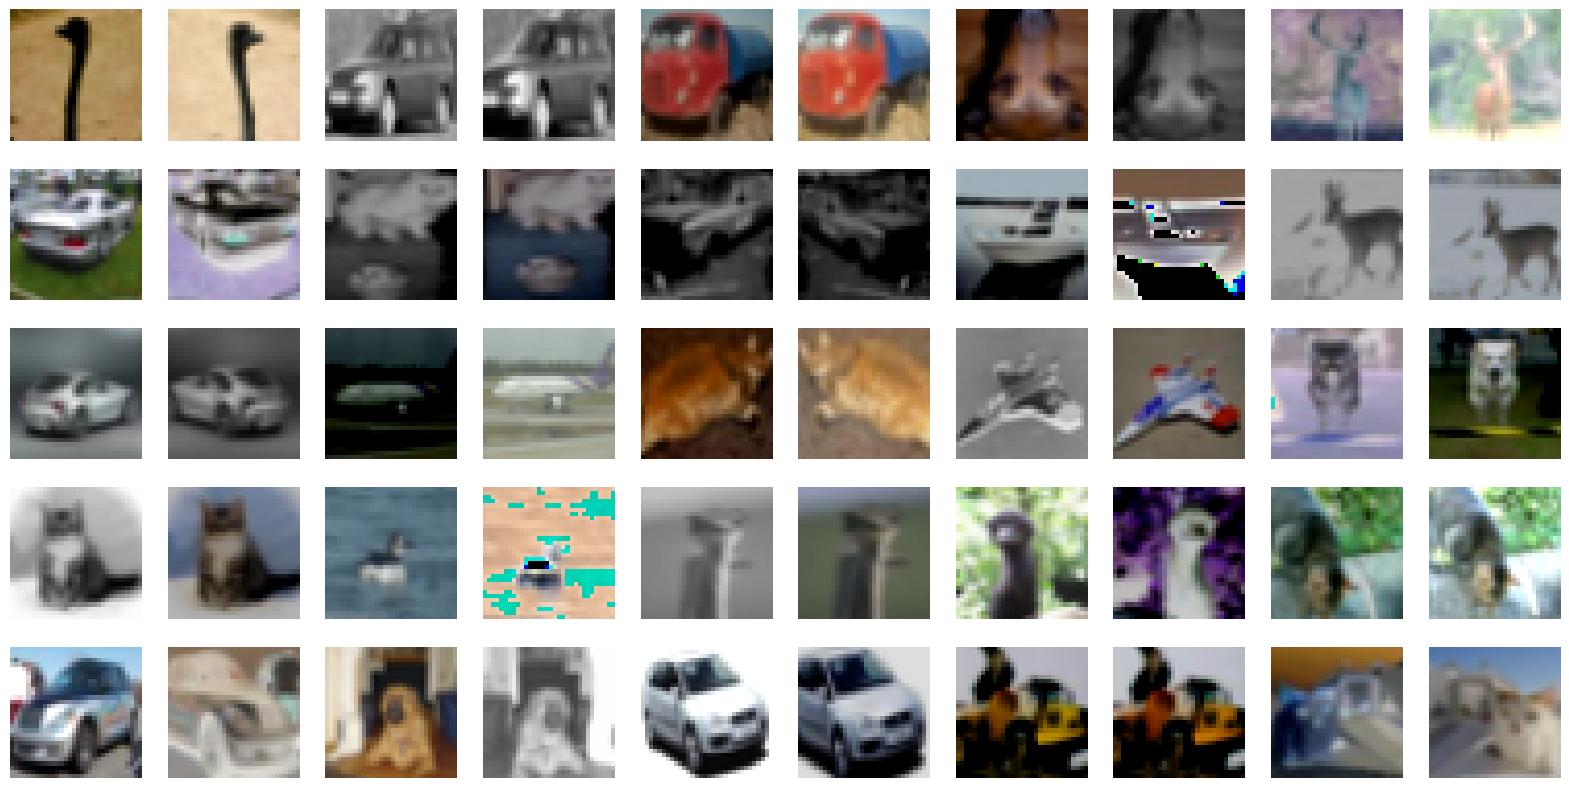

In [6]:
samples = next(iter(ssl_ds))
plt.figure(figsize=(20, 10))
for n in range(25):
    ax = plt.subplot(5, 10, (n + 1)*2 - 1)
    plt.imshow(samples[0][n].numpy())
    plt.axis("off")

    ax = plt.subplot(5, 10, (n + 1)*2)
    plt.imshow(samples[1][n].numpy())
    plt.axis("off")
plt.show()

From the above, we can see that we have pairs of images, with each image in the pair having some different augmentations applied. All told, our generator and augmentations are working.

## Backbone Network

As per our other Siamese adventures, we need a backbone model, which we will then get some embeddings from. In other examples and papers, you will often see the terms *encoder* and *projector* used with respect to this stuff. The *encoder* is usually some large convolutional backbone (like a ResNet), and the *projector* is then one (or more) dense layers attached to the end of this that project the features learned by the encoder into some latent space. This really is no different to what we've already been doing.

Here, I'm going to use our simple ResNet models. In particular, I'm going to use ResNet-v2. I've found this to work better, than other options I tried (I'm looking at you VGG-like models and MobileNet).

In [7]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """
    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)

    return y


def resnet_v2(inputs, filters, num_res_blocks, pool_size):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.

    # Arguments
        inputs (layer):         the input tensor
        filters ([int]):        number of filters in each stage, length of list determines number of stages
        num_res_blocks (int):   number of residual blocks per stage
        pool_size (int):        size of the average pooling at the end

    # Returns
        output after global average pooling and flatten, ready for output
    """

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

def ssl_model(inputs, filters = [16, 32, 64], num_res_blocks = 3, pooling_size = 8):
    
    embedding = resnet_v2(inputs, filters, num_res_blocks, pooling_size)

    return keras.Model(inputs, embedding, name='ssl_model')

## Approach 1: Naive Siamese Network

We'll start with what is perhaps the obvious starting point. It will also fail, but we'll go ahead with it anyway. We'll train a simple siamese network, just using our augmented pairs. This means that our network will only ever see positive pairs, so the trivial solution is to just learn a constant embedding (i.e. nothing useful).

I've set this up a bit different to how we've done things in the previous metric learning examples. Rather than setup the two branches, we'll sub-class the `keras.Model` class and build the metric learning bit into the `train_step` function.

In [8]:
class SSL_Siamese(keras.Model):

    # initialise the model
    def __init__(self, encoder):
        super(SSL_Siamese, self).__init__()
        # we need to create the actual model, this will use the function that we've defined above
        self.model = encoder
        # and track the loss
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    # training step
    def train_step(self, data):
        # unpack the data into the two sets of images
        ds_one, ds_two = data

        # forward pass through the model, pass each set of images through, and then normalise each
        with tf.GradientTape() as tape:
            e1, e2 = self.model(ds_one), self.model(ds_two)
            e1 = tf.math.l2_normalize(e1, axis=1)
            e2 = tf.math.l2_normalize(e2, axis=1)
    
            # minimise the difference between the two different versions
            # of the data
            loss = self.loss(e1, e2)

        # compute gradients and update the model parameters
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # monitor the loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

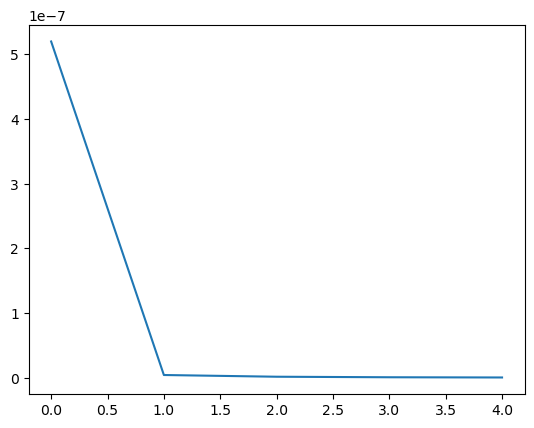

In [9]:
if (APPROACH_1):
    # create the model and compile it
    ssl_siamese = SSL_Siamese(encoder = ssl_model(keras.Input((32, 32, 3))))
    ssl_siamese.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error, 
                       jit_compile=False)

    # I could train this for longer, but there's really no point, it's not going to learn anything
    history = ssl_siamese.fit(ssl_ds, epochs=5, verbose = False)
    plt.plot(history.history["loss"])
    plt.show()

The above loss plot shows that our model converged quite fast, and has reached a loss of 0. You may think, *"oh that's good, our model trained really quickly"*. As you'll soon see, this is not good.

To evaluate our self-supervised models, we'll:
* Use t-SNE to visualise the embedding space, to give us a sense of what we've learned
* Train a very simple classifier (a single dense layer) on top of the learned set of frozen weights. If we've learnt a good representation, we'll be able to seperate the classes out easily.

These will both give us a sense of if our model has learnt a good representation of the data.

I0000 00:00:1707345471.037172     546 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


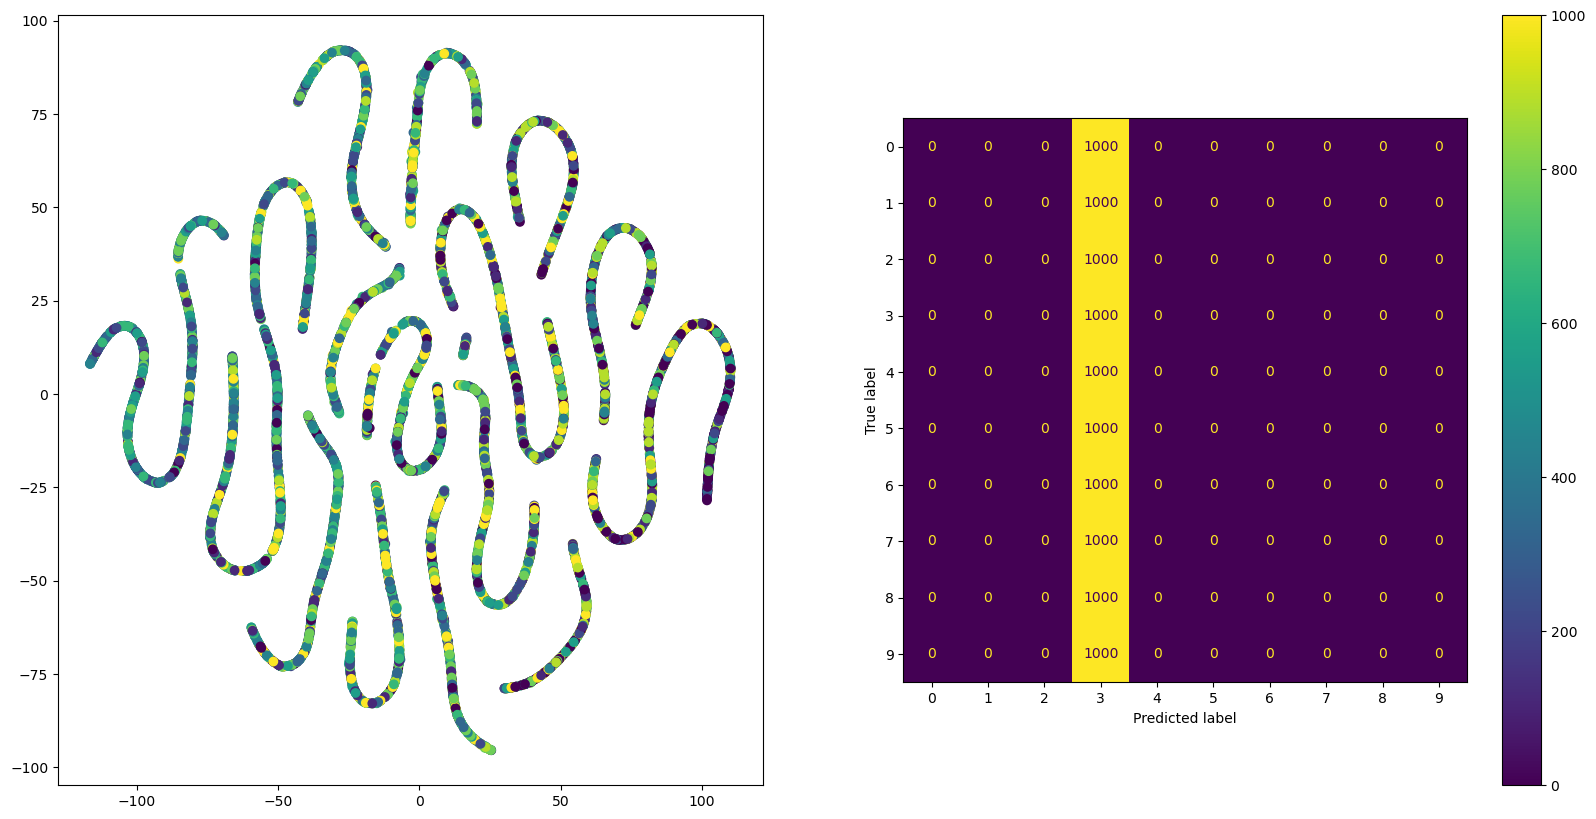

In [10]:
def eval_model(ssl_model, x_train, y_train, x_test, y_test):

    # t-sne
    # compute embeddings
    embeddings = ssl_model.predict(x_test, verbose=False)
    # pass into t-sne
    tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
    # plot the result
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test);

    # simple classifier
    simple_classifier_model = keras.models.Sequential(
    [
        # our model
        ssl_model,
        # single dense layer, 10 outputs for the 10 classes
        keras.layers.Dense(10, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.02)),
    ])
    # set the first layer, i.e. our model, to be fixed
    simple_classifier_model.layers[0].trainable = False

    # train the classifier
    simple_classifier_model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", \
                                    metrics=["accuracy"], jit_compile=False)
    simple_classifier_model.fit(x_train, y_train, epochs=10, verbose=False)

    # plot a confusion matrix for the classifier
    ax = fig.add_subplot(1, 2, 2)    
    indexes = tf.argmax(simple_classifier_model.predict(x_test, verbose=False), axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
if (APPROACH_1):
    eval_model(ssl_siamese.model, x_train, y_train, x_test, y_test)    

In this case, we can clearly see that it has not leant anything useful. Our model has, as expected, learned a trivial solution and collapsed.

## Approach 2: SimSiam

There are many ways to deal with the above issue that we're seeing. One option is to make our siamese network asymmetric, and this is the approach taken by [SimSiam](https://arxiv.org/pdf/2011.10566.pdf]) (and a bunch of other methods). We don't train two different encoders, we still have just the one that's shared, but we also have some very small light weight *predictor* network that is structured like an autoencoder (i.e. it's output is the same size and shape as the input) and sits on-top of the encoder. This then works as follows:
* We have our two batches of data, $B_1$ and $B_2$, our encoder $f_{enc}$, and our predictor $f_{pred}$.
* We pass our data through the encoder, getting $z_1 = f_{enc}(B_1)$ and $z_2 = f_{enc}(B_2)$
* We pass the output of the encoder through the predictor, getting $p_1 = f_{pred}(z_1)$ and $p_2 = f_{pred}(z_2)$
* We compare the encoder outputs from one side, to the predictor outputs from the other to get our loss, $l_{ov} = loss(z_1, p_2) + loss(z_2, p_1)$, where $l_{ov}$ is the overall loss

There's a few other details that we're glossing over in the above (like what the loss function is, and this thing called a *stop gradient* operator which is actually really important to the model working), but that's the broad idea. This asymmetry results in a network that can learn from positive pairs only.

The below code is taken from [here](https://keras.io/examples/vision/simsiam/) with minor modifications.

In [11]:
# predictor network fo the SimSiam model. note that this has an auto-encoder-like structure
def simsiam_predictor(embedding_size = 128, latent_dim_size = 32):

    # input is the size of the embedding
    inputs = keras.Input((embedding_size, ))
    # we'll project that down to a smaller latent representation
    x = layers.Dense(latent_dim_size, kernel_regularizer=keras.regularizers.l2(0.005), activation=None)(inputs)    
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # then project back up to the same size 
    output = layers.Dense(embedding_size)(x)

    return keras.Model(inputs, output, name='simsiam_predictor')

# p is the output from the predictor on one side of the network, 
# z is the output of the encoder on the other side
def simsiam_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)

    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

# class for the SimSiam model
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = simsiam_loss(p1, z2) / 2 + simsiam_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

We can now create and train our model. Compared to our simple (and defective) first attempt we'll:
* Not provide a loss function, as that's baked into `train_step` in the model class
* Train for 20 epochs rather than 5, as we're actually going to learn something

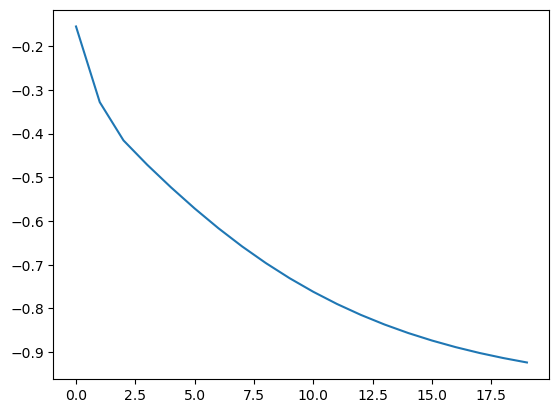

In [12]:
keras.backend.clear_session()

if (APPROACH_2):
    # create the model and compile it
    num_training_samples = len(x_train)
    steps = 100 * (num_training_samples // BATCH_SIZE)
    sim_siam = SimSiam(encoder = ssl_model(keras.Input((32, 32, 3))), \
                      predictor = simsiam_predictor())

    # the optimiser choice is important here, as is the initial learning rate. We'll use a decay function 
    # to slow the learning as we go and prevent the representation from collapsing. Note that if you start
    # with too fast a learning rate things may also collapse.
    lr_decayed_fn = keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.00025, decay_steps=steps)
    sim_siam.compile(optimizer=keras.optimizers.SGD(lr_decayed_fn), jit_compile=False)

    # Train this for longer than our first model
    history = sim_siam.fit(ssl_ds, epochs=20, verbose = False)
    plt.plot(history.history["loss"])
    plt.show()

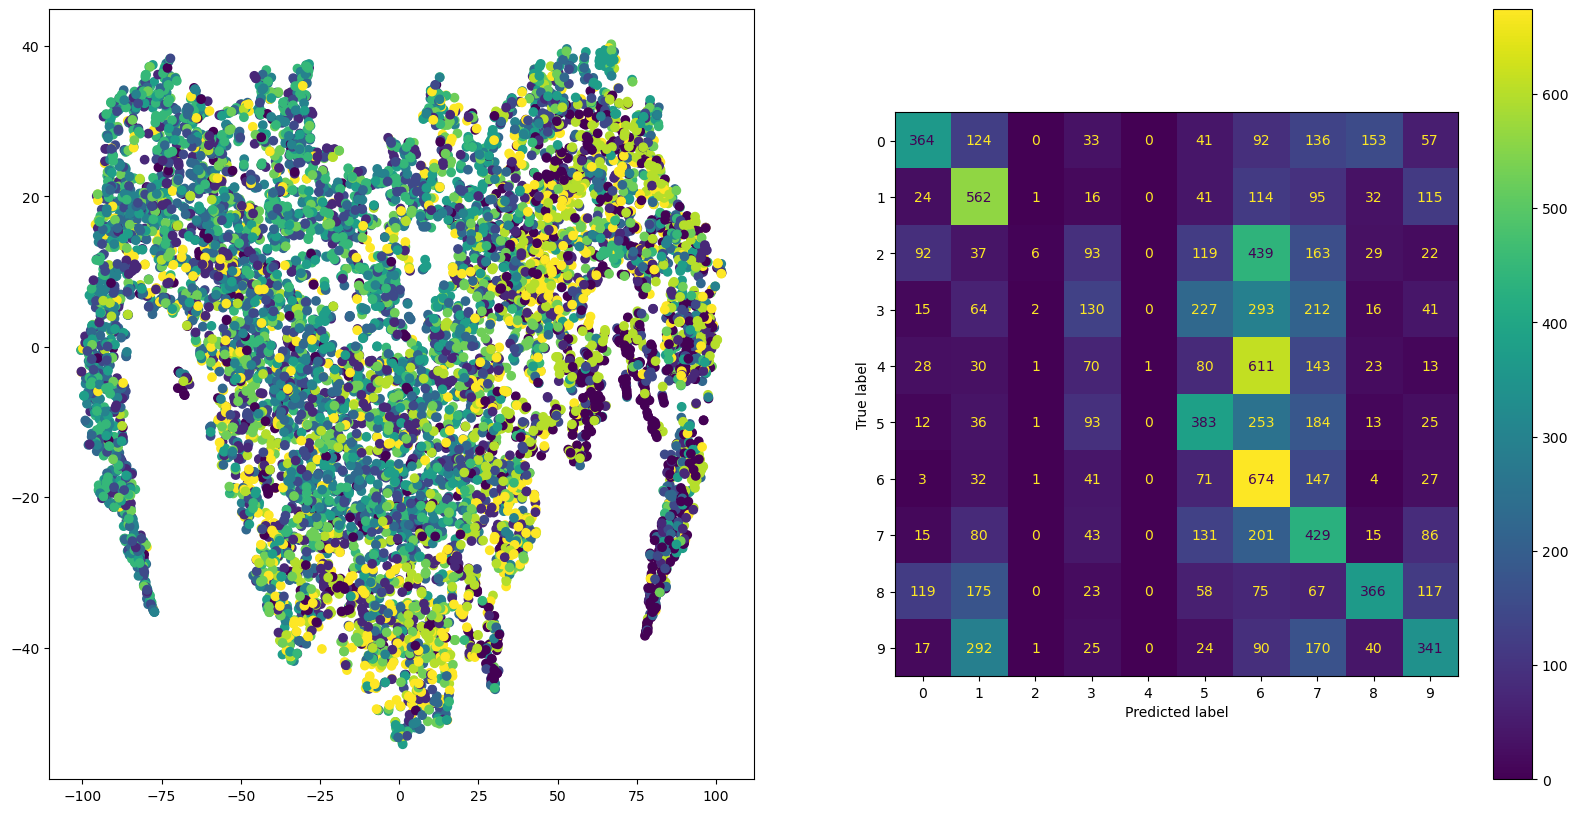

In [13]:
if (APPROACH_2):
    eval_model(sim_siam.encoder, x_train, y_train, x_test, y_test)    

Considering the results, we can see that we've learnt a reasonable representation, without any labels. There is obviously still a lot of scope for further improvement here. Aside from the fact that we could train for longer still, we are limited by the size of our network. As we've had for really all of our metric learning examples, the network is not big.

## Approach 3: Barlow Twins

Approach 2 fell into asymmetric network box, this one falls into the funky loss function box. This has been adapted from [here](https://keras.io/examples/vision/barlow_twins/), and the original paper is [here](https://arxiv.org/pdf/2103.03230.pdf).

The Barlow Twins network introduces the *Barlow Loss*, which seeks to minimise redundancy in the loss. During training, the network works as follows:
* As per earlier methods in this (long, long) example, we'll feed in two versions of the data and pass that through the same network, getting $z_1 = f_{enc}(B_1)$ and $z_2 = f_{enc}(B_2)$, where our embeddings are all of length $N$. 
* Then, we'll compute the cross correlation, $C$, between $z_1$ and $z_2$. The resulting cross-correlation matrix is then used to create our loss, which has two components:
  * The *invariance* term, which comes from the diagonal of the cross correlation matrix. $z_1$ and $z_2$ are the embeddings that result from passing two versions of the same data through the same backbone. Ideally, $z_1$ and $z_2$ should be identical, or at the very least should have some strong correlation between them. As the diagonal of $C$ is measuring the correlation between corresponding elements in $z_1$ and $z_2$ (i.e. the first diagonal element is the correlation between the first embedding dimension in $z_1$ and $z_2$), if there is a perfectly linear relationship between $z_1$ and $z_2$, we'll see values of $1$ along this diagonal. Our *invariance* term want's to maximise this linear relationship, and thus is given by $L_{inv} = \sum_{i=1}^{N}(1 - C_{ii})^2$, i.e. for each element along the diagonal, we subtract it from 1 and square the result. Then we sum these up. 
  * The *redundancy reduction* term, which comes from everywhere else. Again thinking about our ideal embedding space, to pack as much information into our embedding as possible we'd like each dimension to be totally independent, which means the cross correlation between $z_1$ and $z_2$, for the off-diagonal elements should be 0. This is what the *redundancy reduction* term aims for, $L_{rr} = \sum_{i=1}^{N}\sum_{j=1, j \neq i}^{N}C_{i,j}^2$, i.e. to minimise the off-diagonal elements and thus reduce redundancy in the representation.
  * Our overall loss then just becomes the sum of these terms, with a weight applied to the second, $L = L_{inv} + \lambda L_{rr}$
  
The nice thing is that this loss function doesn't have a trivial solution, so we don't need any other fancy tricks to learn a representation using the Barlow Loss. It's also been shown to scale better to very large dimensional embeddings, and not require massive batch sizes.

In [14]:
# Barlow Loss Class
# The Barlow loss is based on the cross-correlation matrix, subclass of keras.losses.Loss
class BarlowLoss(keras.losses.Loss):
    
    # init the loss with the batch size
    def __init__(self, batch_size, lambda_amt = 5e-3):
        super(BarlowLoss, self).__init__()
        # lambda, used when summing the invariance term and redundancy reduction term
        self.lambda_amt = lambda_amt
        self.batch_size = batch_size

    # set the diagonals of the cross correlation matrix zero. Used in the redundancy reduction
    # loss term which takes the sum of squares of the off-diagonal values
    # inputs
    #  - A tf.tensor that represents the cross correlation matrix
    # outputs
    #  - A tf.tensor which represents the cross correlation matrix with its diagonals as zeros.
    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag)

    # Get the barlow loss. Seek to have 1's on the diagonal, and 0's everywhere else. Loss fuction
    # is composed on two terms, the invariance term and the redundancy reduction term:
    #  - invariance term subtracts the values on the diagonal from 1, and squares the result
    #    term is minimised if the diagonal values are 1
    #  - redundancy reduction term aims to minimise the rest of the matrix (off-diagonal values), and is
    #    the sum of the square of these terms
    # Both terms are summed, with a weight, lambda, applied to the redundancy reduction term
    # inputs
    #  - A tf.tensor that represents the cross correlation matrix
    # outputs
    #  - barlow loss for the provided cross correlation matrix
    def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        # subtracts diagonals from one and square the result (invariance term)
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)

        # get off diagonal terms, square them, multiply by lambda (redundancy reduction term)
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt

        # sum the terms and return the result
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)
        return loss

    # normalise a set of predictions
    def normalize(self, output: tf.Tensor) -> tf.Tensor:
        return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(
            output, axis=0)

    # create a cross-correlation matrix from two sets of predictions, each containing 
    # predictions of length embedding_size. Function transposes the first of predictions, 
    # and multplies these by the second to obtain a tensor of size 
    # embedding_size x embedding_size. The result is divided by the batch size.
    # inputs
    #  - A normalized version of the first set of embeddings
    #  - A normalized version of the second set of embeddings
    # outputs
    #  - cross correlation matrix between the two inputs
    def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
        return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size

    # call the loss. Normalise the two tensors, create the cross correlation matrix,
    # and compute the loss
    # inputs
    #  - embeddings for the first set of augmented data
    #  - embeddings for the second set of augmented data
    # output
    #  - computed loss
    def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
        # normalise tensors
        z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        # compute cross correlation
        c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        # compute loss
        loss = self.cross_corr_matrix_loss(c)
        return loss

In [15]:
# class for the Barlow Twins model
class BarlowModel(keras.Model):
    def __init__(self, encoder):
        super(BarlowModel, self).__init__()

        self.encoder = encoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # get the two augmentations from the batch
        y_a, y_b = data

        # Forward pass through the encoder
        with tf.GradientTape() as tape:
            # get two versions of predictions
            z_a, z_b = self.encoder(y_a, training=True), self.encoder(y_b, training=True)
            loss = self.loss(z_a, z_b)

        # Compute gradients and update the parameters.
        grads_model = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grads_model, self.encoder.trainable_variables))
        
        # monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

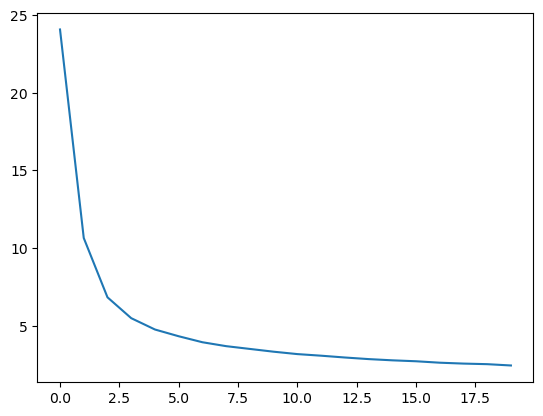

In [16]:
keras.backend.clear_session()

if (APPROACH_3):
    # create the model and compile it
    bm = BarlowModel(encoder = ssl_model(keras.Input((32, 32, 3))))
    bm.compile(optimizer=keras.optimizers.Adam(), loss = BarlowLoss(BATCH_SIZE), jit_compile=False)

    # Train this for 20 epochs again
    history = bm.fit(ssl_ds, epochs=20, verbose = False)
    plt.plot(history.history["loss"])
    plt.show()

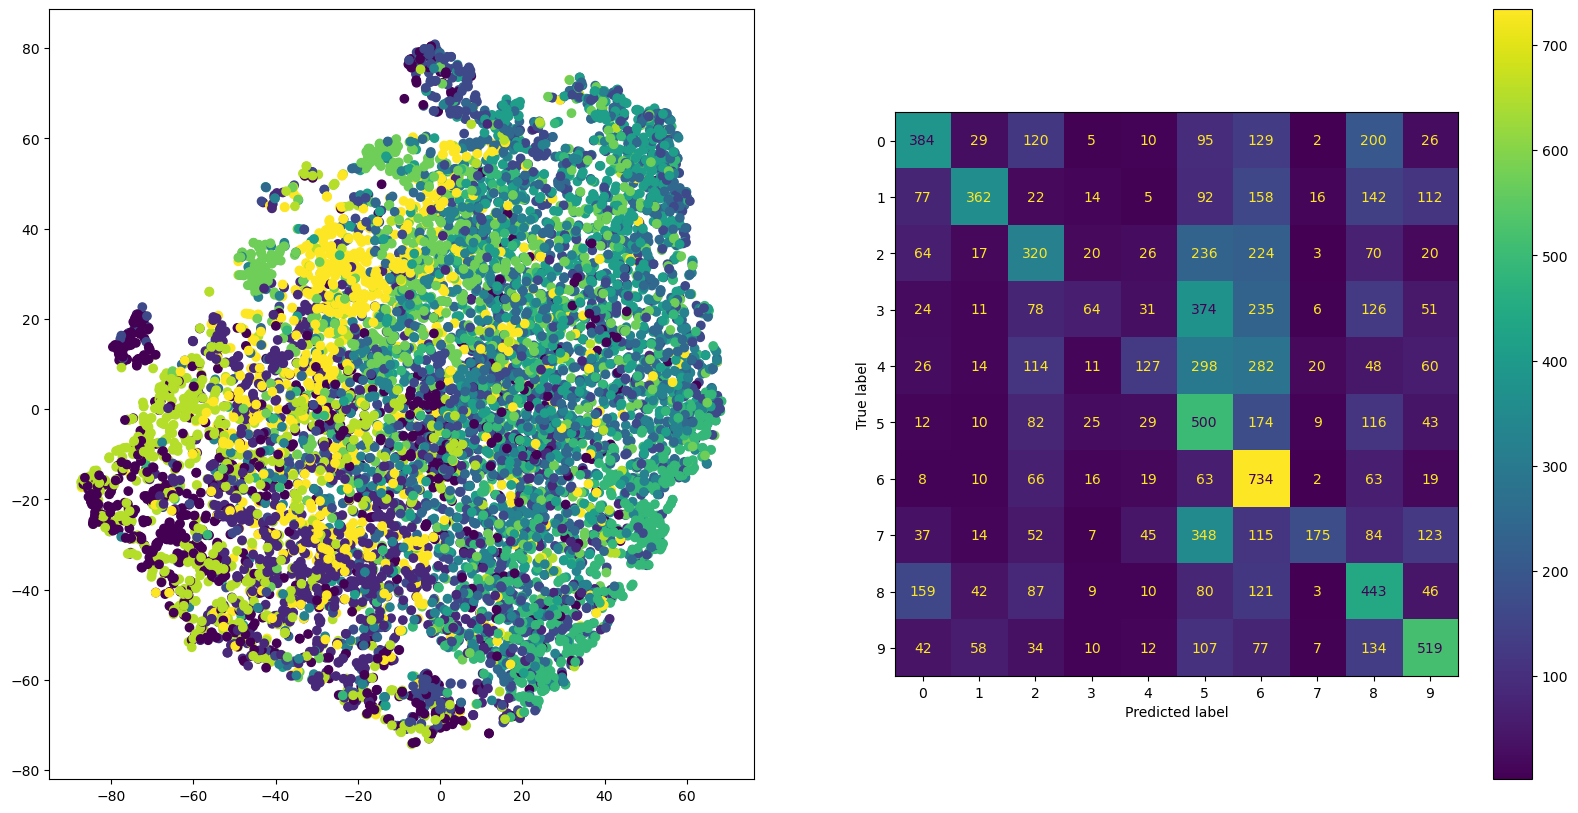

In [17]:
if (APPROACH_3):
    eval_model(bm.encoder, x_train, y_train, x_test, y_test)    

This network has worked well. It's not given us perfect results by any stretch, but without any labels we've managed to learn a (somewhat) reasonable seapration of the data. Training this for longer would also help us futher, but it's run for long enough in this example.

## Some Final Musings

This example has covered three approaches:
* The first doesn't work. It has a trivial solution, which the network finds quickly, and runs with. This is only here to show that this doesn't work.
* The second, SimSiam, sort of works. This one was a bit of a bugger to get running in a compact form if I'm honest. It's reasonably stable with the ResNet's, but was very unhappy when asked to use a VGG-like network. It's also very prone to collapsing. Set the learning rate too fast, or use something other than SGD, and it all goes wrong.
* The third, Barlow Twins, just works, and seems happy with different learning rates, optimisers, networks, etc. This is also (to me) the more elegant approach too. We don't need to stuff around with introducing additional operations into the network to create asymmetry, or deal with stop gradient operations. We simply have a cleverly crafted loss function that encourages useful thing in our learned embedding space (reduced redundancy).

Note that we've used the same backbone network in all three cases, so the changes that we're seeing in performance are a result of the learning stratergy employed.

As usual, our backbone network is a limitation here. A bigger network will give us the opertunity to learn a richer representation. It will also take longer, need more memory, and all of those other things.

### But what would I do with one of these things?

Possibly, you're feeling this example has been [something along the lines of](https://www.youtube.com/watch?v=tO5sxLapAts):
* Phase 1: Train a representation using self-supervised learning
* Phase 2: ????
* Phase 3: Profit

But what is Phase 2?? As with life, Phase 2 is whatever you make it. But, it could be:
* A supervised learning task. For example, you could have some massive amount of data, but perhaps very little of it is labelled. So you learn a representation on the data using a self-supervised method, and then tune this to your target task using the few labels that you have. 
* A clustering tasks. Again, you have some massive amount of data, and this time no labels at all (and no interest in annotating any). So you could train a representation, and then cluster data based on this. You may then use this clustering to bootstrap some labelling, or some other subsequent task.

As the above suggests, self-supervised learning is generally going to be the first step in some bigger piece of work - it's unlikely to be the solution to some problem itself. As noted way back at the start of all this, it's also very much on the peripheray of CAB420  - but it's also cool.